<a href="https://colab.research.google.com/github/Untick/InspectrumClinic_RS_gr1/blob/Kozlov-Alexey-folder/Kozlov%20Alexey/InspectrumClinic_gr1_akozlov_20230522_03week.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Рекомендательная система для профпатолога (INSPECTRUM CLINIC)**

Алексей Козлов 2023.05.22 - 2023.05.29 (3-я неделя): Подбор гиперпараметров,улучшение точности работы НС

# Импорт библиотек

In [ ]:
# Загрузка файлов из облака
import gdown
# Библиотека для работы с массивами данных
import numpy as np
# Библиотека для обработки и анализа данных
import pandas as pd
# Библиотека для построения графиков
import matplotlib.pyplot as plt
# Команда для отображения графики в ячейках среды Google Colaboratory
%matplotlib inline
# Библиотека для построения графиков
import seaborn as sns
#Для генерации случайных чисел
import random 
# Для округления
import math
import re

# Подключение класса создания модели Sequential
# Sequential – модуль для создания последовательной модели нейронной сети
from tensorflow.keras.models import Sequential, Model
# Подключение класса Dense - полносвязный слой
# Dense – линейный (полносвязный) слой. Из таких слоев будет создана ваша нейросеть
from tensorflow.keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten
# utils – модуль с полезными инструментами для подготовки данных
#Используем для to_categoricall
from tensorflow.keras import utils
from tensorflow.keras.optimizers import Adam,Adadelta,SGD,Adagrad,RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
# подключаем колбэки
from tensorflow.keras.callbacks import LambdaCallback

from sklearn.preprocessing import StandardScaler
# Для разбивки на выборки
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

from IPython.display import clear_output

# Для работы с датами
from datetime import datetime

# Загрузка файла с исходными данными

In [ ]:
# Загрузка файла датасета
url1 = 'https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx'
url2 = '/content/InspectrumClinic1.xlsx'
gdown.download(url1, url2, quiet=False)

Downloading...
From: https://storage.yandexcloud.net/terratraineeship/23_InspectrumClinic_RS/datasets/%D0%B4%D0%B0%D1%82%D0%B0%D1%81%D0%B5%D1%82%20%D0%BF%D1%80%D0%BE%D1%84%D0%BF%D0%B0%D1%82%D0%BE%D0%BB%D0%BE%D0%B3%20%D1%87%D0%B0%D1%81%D1%82%D1%8C.xlsx
To: /content/InspectrumClinic1.xlsx
100%|██████████| 32.4M/32.4M [00:02<00:00, 14.2MB/s]


'/content/InspectrumClinic1.xlsx'

In [ ]:
# Чтение данных (df - DataFrame)
df1 = pd.read_excel(url2)

In [ ]:
# Выведем информацию о заполненности ячеек каждого признака
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1982 entries, 0 to 1981
Columns: 4587 entries, ДокументПрохождениеМедосмотра to Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление
dtypes: bool(1), datetime64[ns](43), float64(1253), object(3290)
memory usage: 69.3+ MB


In [ ]:
print(f'размеры датафрейма: df1: {df1.shape}')

размеры датафрейма: df1: (1982, 4587)


# Добаления id-колонки

In [ ]:
# Клиент
nan_lst = df1[df1['Клиент'].isnull()].index
print(f'"Клиент": число строк с пустыми значениями: {len(nan_lst)}')
uname_lst = df1['Клиент'].unique().tolist()
print(f'"Клиент": число строк с уникальными значениями: {len(uname_lst)}')

"Клиент": число строк с пустыми значениями: 0
"Клиент": число строк с уникальными значениями: 1911


**'Клиент' - это скорее всего ФИО и значения в этой колонке не уникальны, они повторяются, поэтому для проверки предсказаний созданной нейронки, добавляю колонку id.**

In [ ]:
# создаем numpy массив integer
id_arr = np.arange(df1.shape[0], dtype=int)
# добавляем новую колонку 'client_id' в DataFrame 'df1' из массива 'id_arr'
df1 = df1.assign(client_id=id_arr)

In [ ]:
print(f'размеры датафрейма: df1: {df1.shape}')
#print(df1.head(3))
#print(df1.tail(2))
df1.head(3)

размеры датафрейма: df1: (1982, 4588)


,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление,client_id
0,7f41ca7e-7dac-11ec-80fc-0cc47aab8067,c91e3407-b81f-11e9-80cf-0cc47aab8067,1976-10-24,Женский,Женский,2022-01-25,Периодический,Периодический,False,23c173a7-30d9-11e7-80d8-708bcd7f83cd,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
1,2ee1f9ac-83dd-11ec-80fc-0cc47aab8067,1a1a5fea-8b7f-11eb-80e8-0cc47aab8067,1987-11-18,Мужской,Мужской,2022-02-02,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
2,9cbb191e-8e24-11ec-80fe-0cc47aab8067,7fe324e0-fa51-11eb-80f6-0cc47aab8067,1985-09-08,Мужской,Мужской,2022-02-15,Периодический,Периодический,False,a6d559b0-7835-11eb-80e8-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2


In [ ]:
df1.tail(2)

,ДокументПрохождениеМедосмотра,Клиент,КлиентДатаРождения,КлиентПол,КлиентПолПредставление,ДатаЗавершенияМедосмотра,ТипМедосмотра,ТипМедосмотраПредставление,ПсихОсвидетельствование,Контрагент,...,Оториноларингология3_Аудиометрия1_ЗначениеПредставление,Оториноларингология1_ЖалобыДополнение_Значение,Оториноларингология1_ЖалобыДополнение_ЗначениеПредставление,Стоматология2_ВП2_Значение,Стоматология2_ВП2_ЗначениеПредставление,Терапия2_ЗаключениеФОГК_Значение,Терапия2_ЗаключениеФОГК_ЗначениеПредставление,Офтальмология1_ДвигательныйАппаратГлазДополнение_Значение,Офтальмология1_ДвигательныйАппаратГлазДополнение_ЗначениеПредставление,client_id
1980,d0358b83-7065-11ed-8109-0cc47aab8067,6261a674-07c8-11e8-80c6-0cc47aab8067,1972-04-17,Женский,Женский,2022-11-30,Периодический,Периодический,False,21f2a93d-68f9-11e6-82dc-d897ba0a5c60,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1980
1981,a15e278b-71f5-11ed-810a-0cc47aab8067,920293ea-32c2-11eb-80e3-0cc47aab8067,1971-09-14,Мужской,Мужской,2022-12-02,Периодический,Периодический,False,4826f33a-06b9-11ea-80d3-0cc47aab8067,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1981


In [ ]:
print(f'размеры датафрейма: df1: {df1.shape}')

размеры датафрейма: df1: (1982, 4588)


# Удаление строк с пустыми и запрещенными значениями в целевой колонке

In [ ]:
# ЗаключениеМК
uconclusion_lst1 = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(uconclusion_lst1)}: {uconclusion_lst1}')

10: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден', nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель']


In [ ]:
# удаляем nan, 'машинист бульдозера', 'Газоспасатель', ' Газоспасатель'
df1 = df1.drop(df1[(df1['ЗаключениеМК'].isnull()) | (df1['ЗаключениеМК'] == 'машинист бульдозера') | (df1['ЗаключениеМК'] == 'Газоспасатель') | (df1['ЗаключениеМК'] == ' Газоспасатель') ].index)
print(f'размеры датафрейма после удаления строк: {df1.shape}')
uconclusion_lst2 = df1['ЗаключениеМК'].unique().tolist()
print(f'{len(uconclusion_lst2)}: {uconclusion_lst2}')

размеры датафрейма после удаления строк: (1571, 4588)
6: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']


# Создаем второй датафрейм для обучения нейросети

In [ ]:
# создаем новый датафрейм, в который будем заносить колонки для обучения нейросети
# создаем копию таблицы с одной колонкой 'ЗаключениеМК'
df2 = df1[['client_id']].copy()
print(f'размеры датафрейма2: {df2.shape}')
df2.head(3)

размеры датафрейма2: (1571, 1)


,client_id
0,0
1,1
2,2


In [ ]:
df2.tail(2)

,client_id
1973,1973
1981,1981


In [ ]:
print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')

размеры датафрейма: df1: (1571, 4588), df2: (1571, 1)


# Категориальные признаки

In [ ]:
# ЗаключениеМК
#~~~~~~~~~~~~~~~~~~~~~~~~
def getConclusionCategory(arg):
  '''
    Получение целевого категориального значения по текстовому описанию
    вход:
        arg: ['Годен', 'ГоденСКоррекциейЗрения', 'ГоденБезРаботНаВысотах', 'НуждаетсяВДообследованииИЛечении', 'ВременноНегоден', 'ОграниченноГоден']
    выход:
        retVal: 0 - не годен, 1 - годен с ограничениями, 2 - годен
  '''
  if ('ГоденСКоррекциейЗрения' == arg) or ('ГоденБезРаботНаВысотах' == arg) or ('ОграниченноГоден' == arg):
    retVal = 1
  elif ('НуждаетсяВДообследованииИЛечении' == arg) or ('ВременноНегоден' == arg):
    retVal = 0
  else:
    retVal = 2

  return retVal

#~~~~~~~~~~~~~~~~~~~~~~~~
conclusion_class_count = 3

# Получаем список значений колонки
col_inx = df1.columns.get_loc('ЗаключениеМК')
col_lst = df1.iloc[:, col_inx].tolist()

# print(col_inx)
# print(f'{len(col_lst)}: {col_lst}')
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'df1 число колонок: {df1.shape[1]}')

# создаем numpy массив integer
i_arr = np.arange(df1.shape[0], dtype=int)

for i in range(df1.shape[0]):
  i_arr[i] = getConclusionCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding
i_arr2 = utils.to_categorical(i_arr, conclusion_class_count)
ohe_lst2 = i_arr2.astype(int).tolist()

# print(f'len(i_arr): {len(i_arr)}, lst: {i_arr}')
# print(f'len(i_arr2): {len(i_arr2)}, lst: {i_arr2}')
# print(f'len(ohe_lst2): {len(ohe_lst2)}, lst: {ohe_lst2}')

# добавляем новую колонку 'ЗаключениеМК' в DataFrame 'df2' из массива 'ohe_lst2'
# добавляем новую колонку 'Возраст' в DataFrame 'df2' из списка 'ohe_lst2'
df2 = df2.assign(ЗаключениеМК=ohe_lst2)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

размеры датафрейма: df1: (1571, 4588), df2: (1571, 2)


,client_id,ЗаключениеМК
0,0,"[0, 0, 1]"
1,1,"[0, 0, 1]"
2,2,"[0, 1, 0]"


In [ ]:
df2.tail(2)

,client_id,ЗаключениеМК
1973,1973,"[0, 0, 1]"
1981,1981,"[0, 0, 1]"


In [ ]:
# Возраст пациента = ДатаЗавершенияМедосмотра - КлиентДатаРождения
#~~~~~~~~~~~~~~~~~~~~~~~~
def getAgeCategory(ageN, ageClassCount):
  '''
    Возраст превращаем в категориальный: до 18лет, далее через 5, всего 11 классов
    вход:
        ageN: возраст в годах
        ageClassCount: число классов
    выход:
        retVal: индекс категории: 0-17: 0, 18-22: 1, 23-27: 2, ...., 73..: 10
  '''
  #age2 = int((arg-13)/5)
  age2 = (ageN-13)/5
  retVal = max(0, min((ageClassCount-1),age2))
  return retVal

#~~~~~~~~~~~~~~~~~~~~~~~~
age_class_count = 11

nan_lst = df1[df1['КлиентДатаРождения'].isnull()].index
print(f'"КлиентДатаРождения": число строк с пустыми значениями: {len(nan_lst)}')
col_inx = df1.columns.get_loc('КлиентДатаРождения')
col_lst = df1.iloc[:, col_inx].tolist()

# print(type(col_lst))
# print(type(col_lst[0]))
# print(col_inx)
# print(f'{len(col_lst)}: {col_lst}')
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'col_lst[0]: {col_lst[0]}, col_lst[1]: {col_lst[1]}, col_lst[2]: {col_lst[2]}, col_lst[1569]: {col_lst[1569]}, col_lst[1570]: {col_lst[1570]}')

datetime_lst1 = []
for time_stamp in col_lst:
  datetime_obj = time_stamp.to_pydatetime()
  datetime_lst1.append(datetime_obj)

#~~~~~~~~~~~~~~~~~~~~~~~~
# ДатаЗавершенияМедосмотра
nan_lst = df1[df1['ДатаЗавершенияМедосмотра'].isnull()].index
print(f'"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')
col_inx = df1.columns.get_loc('ДатаЗавершенияМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()

# print(col_inx)
# print(f'{len(col_lst)}: {col_lst}')
# print(f'col_lst[0]: {col_lst[0]}, col_lst[1]: {col_lst[1]}, col_lst[2]: {col_lst[2]}, col_lst[1569]: {col_lst[1569]}, col_lst[1570]: {col_lst[1570]}')

datetime_lst2 = []
for time_stamp in col_lst:
  datetime_obj = time_stamp.to_pydatetime()
  datetime_lst2.append(datetime_obj)

#~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(df1.shape[0]):
  delta_dates21 = datetime_lst2[i].date() - datetime_lst1[i].date()
  delta_days21 = delta_dates21.days
  delta_years21 = delta_days21 // 365
  i_arr[i] = getAgeCategory(delta_years21, age_class_count)
  #if 1569 == i:
  #  print(f'i: {i}, delta_dates21: {delta_dates21}, delta_days21: {delta_days21}, delta_years21: {delta_years21}, i_arr[i]: {i_arr[i]}')

# Преобразование массива в формат one_hot_encoding
i_arr2 = utils.to_categorical(i_arr, age_class_count)
ohe_lst2 = i_arr2.astype(int).tolist()

# print(f'age_class_count: {age_class_count}')
# print(f'{len(datetime_lst1)}: 0: {datetime_lst1[0]}, 1: {datetime_lst1[1]}, 2: {datetime_lst1[2]} ..., 1569: {datetime_lst1[1569]}, 1570: {datetime_lst1[1570]}')
# print(f'{len(datetime_lst2)}: 0: {datetime_lst2[0]}, 1: {datetime_lst2[1]}, 2: {datetime_lst2[2]} ..., 1569: {datetime_lst2[1569]}, 1570: {datetime_lst2[1570]}')
# print(f'{len(i_arr)}: 0: {i_arr[0]}, 1: {i_arr[1]}, 2: {i_arr[2]} ..., 1569: {i_arr[1569]}, 1570: {i_arr[1570]}')
# print(f'{len(i_arr2)}: 0: {i_arr2[0]}, 1: {i_arr2[1]}, 2: {i_arr2[2]} ..., 1569: {i_arr2[1569]}, 1570: {i_arr2[1570]}')
# print(f'{len(ohe_lst2)}: 0: {ohe_lst2[0]}, 1: {ohe_lst2[1]}, 2: {ohe_lst2[2]} ..., 1569: {ohe_lst2[1569]}, 1570: {ohe_lst2[1570]}')

# добавляем новую колонку 'Возраст' в DataFrame 'df2' из списка 'ohe_lst2'
df2 = df2.assign(Возраст=ohe_lst2)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

"КлиентДатаРождения": число строк с пустыми значениями: 0
"ДатаЗавершенияМедосмотра": число строк с пустыми значениями: 0
размеры датафрейма: df1: (1571, 4588), df2: (1571, 3)


,client_id,ЗаключениеМК,Возраст
0,0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]"
1,1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
2,2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"


In [ ]:
df2.tail(2)

,client_id,ЗаключениеМК,Возраст
1973,1973,"[0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]"
1981,1981,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]"


In [ ]:
# КлиентПол
#~~~~~~~~~~~~~~~~~~~~~~~~
def getGenderCategory(arg):
  '''
    Бинарный пол клиента
    вход:
        arg: ['Женский', 'Мужской']
    выход:
        retVal: 0 - Женский, 1 - Мужской
  '''
  if 'Женский' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

#~~~~~~~~~~~~~~~~~~~~~~~~
unique_lst = df1['КлиентПол'].unique().tolist()
print(f'{len(unique_lst)}: {unique_lst}')
nan_lst = df1[df1['КлиентПол'].isnull()].index
print(f'"КлиентПол": число строк с пустыми значениями: {len(nan_lst)}')

#~~~~~~~~~~~~~~~~~~~~~~~~
col_inx = df1.columns.get_loc('КлиентПол')
col_lst = df1.iloc[:, col_inx].tolist()

# print(col_inx)
# print(f'{len(col_lst)}: {col_lst}')
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'df1 число колонок: {df1.shape[1]}')

for i in range(df1.shape[0]):
  i_arr[i] = getGenderCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# ohe_lst2 = i_arr.astype(int).tolist()

# print(f'len(i_arr): {len(i_arr)}, lst: {i_arr}')
# print(f'len(ohe_lst2): {len(ohe_lst2)}, lst: {ohe_lst2}')

# добавляем новую колонку 'КлиентПол' в DataFrame 'df2' из списка 'i_arr'
# df2 = df2.assign(КлиентПол=ohe_lst2)
df2 = df2.assign(КлиентПол=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

2: ['Женский', 'Мужской']
"КлиентПол": число строк с пустыми значениями: 0
размеры датафрейма: df1: (1571, 4588), df2: (1571, 4)


,client_id,ЗаключениеМК,Возраст,КлиентПол
0,0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0
1,1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1
2,2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1


In [ ]:
df2.tail(2)

,client_id,ЗаключениеМК,Возраст,КлиентПол
1973,1973,"[0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1
1981,1981,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1


In [ ]:
# ТипМедосмотра
#~~~~~~~~~~~~~~~~~~~~~~~~
def getTypeMedExaminationCategory(arg):
  '''
    Бинарный Тип Медосмотра
    вход:
        arg: ['Периодический', 'Предварительный']
    выход:
        retVal: 0 - Периодический, 1 - Предварительный
  '''
  if 'Периодический' == arg:
    retVal = 0
  else:
    retVal = 1
  return retVal

#~~~~~~~~~~~~~~~~~~~~~~~~
unique_lst = df1['ТипМедосмотра'].unique().tolist()
print(f'{len(unique_lst)}: {unique_lst}')
nan_lst = df1[df1['ТипМедосмотра'].isnull()].index
print(f'"ТипМедосмотра": число строк с пустыми значениями: {len(nan_lst)}')

#~~~~~~~~~~~~~~~~~~~~~~~~
col_inx = df1.columns.get_loc('ТипМедосмотра')
col_lst = df1.iloc[:, col_inx].tolist()

# print(col_inx)
# print(f'{len(col_lst)}: {col_lst}')
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'df1 число колонок: {df1.shape[1]}')

for i in range(df1.shape[0]):
  i_arr[i] = getTypeMedExaminationCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'ТипМедосмотра' в DataFrame 'df2' из списка 'i_arr'
# df2 = df2.assign(ТипМедосмотра=ohe_lst2)
df2 = df2.assign(ТипМедосмотра=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

2: ['Периодический', 'Предварительный']
"ТипМедосмотра": число строк с пустыми значениями: 0
размеры датафрейма: df1: (1571, 4588), df2: (1571, 5)


,client_id,ЗаключениеМК,Возраст,КлиентПол,ТипМедосмотра
0,0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0
1,1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0
2,2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0


In [ ]:
df2.tail(2)

,client_id,ЗаключениеМК,Возраст,КлиентПол,ТипМедосмотра
1973,1973,"[0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,0
1981,1981,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,0


In [ ]:
# ПсихОсвидетельствование
#~~~~~~~~~~~~~~~~~~~~~~~~
unique_lst = df1['ПсихОсвидетельствование'].unique().tolist()
print(f'{len(unique_lst)}: {unique_lst}')
nan_lst = df1[df1['ПсихОсвидетельствование'].isnull()].index
print(f'"ПсихОсвидетельствование": число строк с пустыми значениями: {len(nan_lst)}')

#~~~~~~~~~~~~~~~~~~~~~~~~
col_inx = df1.columns.get_loc('ПсихОсвидетельствование')
col_lst = df1.iloc[:, col_inx].tolist()

# print(col_inx)
# print(f'{len(col_lst)}: {col_lst}')
# print(f'df1 число строк: {df1.shape[0]}')
# print(f'df1 число колонок: {df1.shape[1]}')

for i in range(df1.shape[0]):
  if False == col_lst[i]:
    i_arr[i] = 0
  else:
    i_arr[i] = 1


# Преобразование массива в формат one_hot_encoding не провожу, так как бинарный тип
# добавляем новую колонку 'ПсихОсвидетельствование' в DataFrame 'df2' из списка 'i_arr'
# df2 = df2.assign(ПсихОсвидетельствование=ohe_lst2)
df2 = df2.assign(ПсихОсвидетельствование=i_arr)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

2: [False, True]
"ПсихОсвидетельствование": число строк с пустыми значениями: 0
размеры датафрейма: df1: (1571, 4588), df2: (1571, 6)


,client_id,ЗаключениеМК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование
0,0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0
1,1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0
2,2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0


In [ ]:
df2.tail(2)

,client_id,ЗаключениеМК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование
1973,1973,"[0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,0,1
1981,1981,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,0,0


In [ ]:
# ДиспансернаяГруппа
#~~~~~~~~~~~~~~~~~~~~~~~~
def getDispensaryGroupCategory(arg):
  '''
    Категориальный Тип ДиспансернаяГруппа
    вход:
        arg: ['I', 'IIIа', 'II', 'IIIб', 'x']
    выход:
        retVal: 0 - x, 1 - 'I', 2 - 'IIIа', 3 - 'II', 4 - 'IIIб'
  '''
  if 'I' == arg:
    retVal = 1
  elif 'IIIа' == arg:
    retVal = 2
  elif 'II' == arg:
    retVal = 3
  elif 'IIIб' == arg:
    retVal = 4
  else:
    retVal = 0

  return retVal

#~~~~~~~~~~~~~~~~~~~~~~~~
dispensary_class_count = 5

unique_lst = df1['ДиспансернаяГруппа'].unique().tolist()
print(f'{len(unique_lst)}: {unique_lst}')
nan_lst = df1[df1['ДиспансернаяГруппа'].isnull()].index
print(f'"ДиспансернаяГруппа": число строк с пустыми значениями: {len(nan_lst)}')

# Колонка "ДиспансернаяГруппа" содержит пустые значения, заполняем их значением "x"
df1['ДиспансернаяГруппа'].fillna('x', inplace=True)
nan_lst = df1[df1['ДиспансернаяГруппа'].isnull()].index
print(f'"ДиспансернаяГруппа": число строк с пустыми значениями после заполнения значением "x": {len(nan_lst)}')
unique_lst = df1['ДиспансернаяГруппа'].unique().tolist()
print(f'{len(unique_lst)}: {unique_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
col_inx = df1.columns.get_loc('ДиспансернаяГруппа')
col_lst = df1.iloc[:, col_inx].tolist()

# print(col_inx)
# print(f'{len(col_lst)}: {col_lst}')
# print(f'len(i_lst): {len(i_lst)}, i_lst: {i_lst}')

#~~~~~~~~~~~~~~~~~~~~~~~~
for i in range(df1.shape[0]):
  i_arr[i] = getDispensaryGroupCategory(col_lst[i])

# Преобразование массива в формат one_hot_encoding
i_arr2 = utils.to_categorical(i_arr, dispensary_class_count)
ohe_lst2 = i_arr2.astype(int).tolist()

# print(f'len(i_arr): {len(i_arr)}, lst: {i_arr}')
# print(f'len(i_arr2): {len(i_arr2)}, lst: {i_arr2}')
# print(f'len(ohe_lst2): {len(ohe_lst2)}, lst: {ohe_lst2}')

# добавляем новую колонку 'ДиспансернаяГруппа' в DataFrame 'df2' из списка 'ohe_lst2'
df2 = df2.assign(ДиспансернаяГруппа=ohe_lst2)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

5: ['I', 'IIIа', 'II', 'IIIб', nan]
"ДиспансернаяГруппа": число строк с пустыми значениями: 9
"ДиспансернаяГруппа": число строк с пустыми значениями после заполнения значением "x": 0
5: ['I', 'IIIа', 'II', 'IIIб', 'x']
размеры датафрейма: df1: (1571, 4588), df2: (1571, 7)


,client_id,ЗаключениеМК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа
0,0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]"
1,1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]"
2,2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]"


In [ ]:
df2.tail(2)

,client_id,ЗаключениеМК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа
1973,1973,"[0, 0, 1]","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]",1,0,1,"[0, 1, 0, 0, 0]"
1981,1981,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]",1,0,0,"[1, 0, 0, 0, 0]"


In [ ]:
# ВредныеФакторы
#~~~~~~~~~~~~~~~~~~~~~~~~
def comma_string_split(arg):
  '''
    Расщепление строки по запятым
    вход:
        arg: строка с запятыми или без запятых
    выход:
        retVal: список строк
  '''
    # if isinstance(arg, list):
    #     # Если передан список, возвращаем его, удаляя пустые строки и приводя все строки к нижнему регистру
    #     return [s.lower().strip() for s in arg if s.strip()]
    # else:
    #     # Если передана строка, разбиваем ее по запятой, удаляем пустые строки и приводим все строки к нижнему регистру
    #     return [s.lower().strip() for s in arg.split(',') if s.strip()]
  # удаляем пробелы в начале и конце строки
  str1 = arg.lower().strip()
  # разбиваем строку по запятым и возвращаем список
  lst1 = str1.split(',')
  # результирующий список
  retVal = list()

  # print(f'arg: {arg}')
  # print(f'str1: {str1}')
  # print(f'lst1: {lst1}')
  # print(f'lst1: {len(lst1)}')

  for item1 in lst1:
    item2 = item1.strip()
    #print(f'  item1: {item1}, item2: {item2}')
    retVal.append(item2)

  return retVal


#~~~~~~~~~~~~~~~~~~~~~~~~
unique_lst = df1['ВредныеФакторы'].unique().tolist()
ulst_count = len(unique_lst)
#print(f'{ulst_count}: {unique_lst}')
print(f'количество уникальных вредных факторов: {ulst_count}')
nan_lst = df1[df1['ВредныеФакторы'].isnull()].index
print(f'"ВредныеФакторы": число строк с пустыми значениями: {len(nan_lst)}')

#~~~~~~~~~~~~~~~~~~~~~~~~
col_inx = df1.columns.get_loc('ВредныеФакторы')
col_lst = df1.iloc[:, col_inx].tolist()
lst_count = len(col_lst)

# print(col_inx)
# print(f'{lst_count}: {col_lst}')

#Harmful Factors
hf_lst = list()
for i in range(ulst_count):
  i_elem = unique_lst[i]
  elem_lst = comma_string_split(i_elem)
  #print(f'i: {i}, i_elem: {i_elem}, elem_lst: {elem_lst}')
  hf_lst += elem_lst

#удаляем дубликаты, а затем преобразовываем результат обратно в список
hf_lst2 = list(set(hf_lst))
hf_lst2.sort(reverse=False)
harmful_factors_class_count = len(hf_lst2)
#удаляем из памяти список
del hf_lst

# print(f'len(hf_lst): {len(hf_lst)}, hf_lst2: {hf_lst}')
# print(f'len(hf_lst2): {len(hf_lst2)}, hf_lst2: {hf_lst2}')
# print(f'harmful_factors_class_count: {harmful_factors_class_count}')

#~~~~~~~~~~~~~~~~~~~~~~~~
#multi_hot_encoding
mhe_lst2 = list()
# пробегаемся по всем строкам колонки
for i in range(df1.shape[0]):
  i_elem = col_lst[i]
  elem_lst = comma_string_split(i_elem)
  #print(f'i: {i}, i_elem: {i_elem}')
  mhe_lst = [0] * harmful_factors_class_count
  #print(f'mhe_lst: {mhe_lst}')
  for item2 in elem_lst:
    inx2 = hf_lst2.index(item2)
    #print(f'    item2: {item2}, inx2: {inx2}')
    mhe_lst[inx2] = 1
  #print(f'mhe_lst: {mhe_lst}')
  #print(f'i: {i}, len(mhe_lst): {len(mhe_lst)}')
  mhe_lst2.append(mhe_lst)

# for i in range(len(mhe_lst2)):
#   print(f'i: {i}, mhe_lst2[i]: {mhe_lst2[i]}')

# добавляем новую колонку 'ВредныеФакторы' в DataFrame 'df2' из списка 'mhe_lst2'
df2 = df2.assign(ВредныеФакторы=mhe_lst2)

print(f'размеры датафрейма: df1: {df1.shape}, df2: {df2.shape}')
df2.head(3)

количество уникальных вредных факторов: 388
"ВредныеФакторы": число строк с пустыми значениями: 0
размеры датафрейма: df1: (1571, 4588), df2: (1571, 8)


,client_id,ЗаключениеМК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы
0,0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


# Простые текстовые признаки

TODO -> добавить с использованием токенайзера

TODO -> иcпользовать три модели functional api

In [ ]:
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # TODO добавить с использованием токенайзера
# #~~~~~~~~~~~~~~~~~~~~~~~~


# # Цех
# #~~~~~~~~~~~~~~~~~~~~~~~~
# # unique_lst = df1['Цех'].unique().tolist()
# # print(f'{len(unique_lst)}: {unique_lst}')
# nan_lst = df1[df1['Цех'].isnull()].index
# print(f'"Цех": число строк с пустыми значениями: {len(nan_lst)}')

# # Колонка "Цех" содержит пустые значения, заполняем их значением "x"
# df1['Цех'].fillna('x', inplace=True)
# nan_lst = df1[df1['Цех'].isnull()].index
# print(f'"Цех": число строк с пустыми значениями после заполнения значением "x": {len(nan_lst)}')

# #TODO -> токенайзер

In [ ]:
# #Профессия
# #~~~~~~~~~~~~~~~~~~~~~~~~
# unique_lst = df1['Профессия'].unique().tolist()
# print(f'{len(unique_lst)}: {unique_lst}')
# nan_lst = df1[df1['Профессия'].isnull()].index
# print(f'"Профессия": число строк с пустыми значениями: {len(nan_lst)}')

# #~~~~~~~~~~~~~~~~~~~~~~~~
# # col_inx = df1.columns.get_loc('Профессия')
# # col_lst = df1.iloc[:, col_inx].tolist()

# #TODO -> токенайзер

**“-МКБ-” типа object-string - скорее всего добавлю как категориальный признак, также как добавил вредные факторы**


In [ ]:
# mkbCols = getColumnsWithString('_МКБ')
# print(f'Колонки, содержащих "_МКБ": {len(mkbCols)}: {mkbCols}')

In [ ]:
# # ПсихиатрияНаркология1_МКБ101
# nanRowInxs = getNanRowInxs(psychnark1_MKB101)
# сolUVals = getColUniqueVals(psychnark1_MKB101)
# print(f'Колонка: "{psychnark1_MKB101}":')
# print(f'  число пустых значений: {len(nanRowInxs)}')
# print(f'  уникальные значения: {сolUVals}')

# Числовые признаки

TODO -> иcпользовать три модели functional api

In [ ]:
#TODO -> ичпользовать три модели  functional api

# Обучение модели 1

In [ ]:
print(f'размеры датафрейма df2: {df2.shape}')
df2.head(3)

размеры датафрейма df2: (1571, 8)


,client_id,ЗаключениеМК,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы
0,0,"[0, 0, 1]","[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1,"[0, 0, 1]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,2,"[0, 1, 0]","[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
#-y_data

# преобразуем списки в отдельные колонки
df4 = df2['ЗаключениеМК'].apply(pd.Series)
print(f'размеры датафрейма df4: {df4.shape}')
#print(df4)

размеры датафрейма df4: (1571, 3)


In [ ]:
# преобразуем в numpy массив типа float
y_data = df4.astype(float).to_numpy()
print('Количество осей: ', y_data.ndim)
print('Форма массива: ', y_data.shape)
print('Количество значений: ', y_data.size)
#print(y_data)

Количество осей:  2
Форма массива:  (1571, 3)
Количество значений:  4713


In [ ]:
#-x_data

# поместим в df3 все кроме столбцов ['client_id','ЗаключениеМК']
df3 = df2.drop(['client_id','ЗаключениеМК'], axis = 1)
df3.head(3)

,Возраст,КлиентПол,ТипМедосмотра,ПсихОсвидетельствование,ДиспансернаяГруппа,ВредныеФакторы
0,"[0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",0,0,0,"[0, 1, 0, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 1, 0, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,"[0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",1,0,0,"[0, 0, 0, 1, 0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [ ]:
# преобразуем списки в отдельные колонки
split_col_names = list()
split_col_names.append('Возраст')
split_col_names.append('ДиспансернаяГруппа')
split_col_names.append('ВредныеФакторы')

for col_name in split_col_names:
  df3 = pd.concat([df3.drop(col_name, axis=1), df3[col_name].apply(pd.Series)], axis=1)

# преобразуем в numpy массив типа float
x_data = df3.astype(float).to_numpy()
print('Количество осей: ', x_data.ndim)
print('Форма массива: ', x_data.shape)
print('Количество значений: ', x_data.size)
#print(x_data)

Количество осей:  2
Форма массива:  (1571, 110)
Количество значений:  172810


In [ ]:
# преобразуем в numpy массив типа float
x_data = df3.astype(float).to_numpy()
print('Количество осей: ', x_data.ndim)
print('Форма массива: ', x_data.shape)
print('Количество значений: ', x_data.size)
#print(x_data)

Количество осей:  2
Форма массива:  (1571, 110)
Количество значений:  172810


In [ ]:
# Переменные-настройки-параметры-для-обучения-сети
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
EPOCHS = 50
VERBOSE = 1
TEST_SIZE_PERCENT = 0.2

#~~~~~~~~~~~~~~~~~~~~~~~~
print(f'LEARNING_RATE: {LEARNING_RATE}')
print(f'BATCH_SIZE: {BATCH_SIZE}')
print(f'EPOCHS: {EPOCHS}')
print(f'VERBOSE: {VERBOSE}')
print(f'TEST_SIZE_PERCENT: {TEST_SIZE_PERCENT}')

LEARNING_RATE: 0.001
BATCH_SIZE: 128
EPOCHS: 50
VERBOSE: 1
TEST_SIZE_PERCENT: 0.2


In [ ]:
# Создание обучающей и тестовой выборки
x_train, x_test, y_train, y_test = train_test_split(x_data, # набор параметров
                                                    y_data, # набор меток классов
                                                    test_size=TEST_SIZE_PERCENT, # процент в тестовую
                                                    shuffle=True, #  перемешивание
                                                    random_state=3) # воспроизводимость

# Выведем размерность полученных выборок
print('Обучающая выборка параметров', x_train.shape)
print('Обучающая выборка меток классов', y_train.shape)
print()
print('Тестовая выборка параметров', x_test.shape)
print('Тестовая выборка меток классов', y_test.shape)

Обучающая выборка параметров (1256, 110)
Обучающая выборка меток классов (1256, 3)

Тестовая выборка параметров (315, 110)
Тестовая выборка меток классов (315, 3)


In [ ]:
# Создание модели
model1 = Sequential()

# Добавление слоев
model1.add(Dense(60, input_dim=x_train.shape[1], activation='relu'))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(30))

model1.add(BatchNormalization())
model1.add(Dropout(0.2))
model1.add(Dense(10))

model1.add(Dense(3, activation = 'softmax'))

In [ ]:
# Компиляция
model1.compile(loss='categorical_crossentropy', 
               optimizer=Adam(learning_rate=LEARNING_RATE), 
               metrics=['accuracy'])

In [ ]:
# Обучение нейронной сети
history1 = model1.fit(x_train,                             # Обучающая выборка параметров
                      y_train,                             # Обучающая выборка меток класса
                      batch_size=BATCH_SIZE,               # Размер батча (пакета)
                      epochs=EPOCHS,                       # Количество эпох обучения
                      validation_split=TEST_SIZE_PERCENT,  # Доля проверочной выборки
                      verbose=VERBOSE)                     # Отображение хода обучения

Epoch 1/50
8/8 [==============================] - 2s 33ms/step - loss: 1.4323 - accuracy: 0.3108 - val_loss: 1.0253 - val_accuracy: 0.6270
Epoch 2/50
8/8 [==============================] - 0s 7ms/step - loss: 1.2358 - accuracy: 0.3566 - val_loss: 0.9844 - val_accuracy: 0.7540
Epoch 3/50
8/8 [==============================] - 0s 7ms/step - loss: 1.1172 - accuracy: 0.4323 - val_loss: 0.9551 - val_accuracy: 0.7857
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 1.0513 - accuracy: 0.4900 - val_loss: 0.9295 - val_accuracy: 0.8492
Epoch 5/50
8/8 [==============================] - 0s 6ms/step - loss: 0.9957 - accuracy: 0.5448 - val_loss: 0.9031 - val_accuracy: 0.8651
Epoch 6/50
8/8 [==============================] - 0s 7ms/step - loss: 0.9626 - accuracy: 0.5478 - val_loss: 0.8723 - val_accuracy: 0.9008
Epoch 7/50
8/8 [==============================] - 0s 6ms/step - loss: 0.9031 - accuracy: 0.6295 - val_loss: 0.8368 - val_accuracy: 0.9048
Epoch 8/50
8/8 [=================

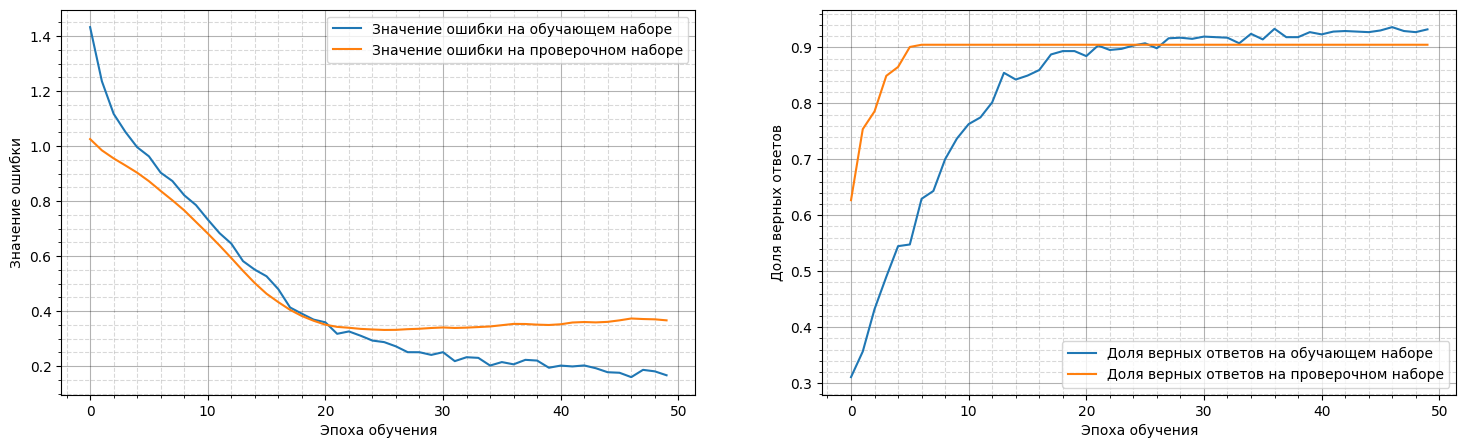

In [ ]:
# Создание полотна для рисунка
plt.figure(figsize=(18,5))

# Задание первой (левой) области для построения графиков
plt.subplot(1, 2, 1)
# Отрисовка графиков 'loss' и 'val_loss' из значений словаря history.history
plt.plot(history1.history['loss'],
         label = 'Значение ошибки на обучающем наборе')
plt.plot(history1.history['val_loss'],
         label = 'Значение ошибки на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение ошибки')
plt.legend()
plt.grid(which = 'major', color = 'black', alpha = 0.3)
plt.minorticks_on()
plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

# Задание второй (правой) области для построения графиков
plt.subplot(1, 2, 2)
# Отрисовка графиков 'accuracy' и 'val_accuracy' из значений словаря history.history
plt.plot(history1.history['accuracy'],
         label = 'Доля верных ответов на обучающем наборе')
plt.plot(history1.history['val_accuracy'],
         label = 'Доля верных ответов на проверочном наборе')
# Задание подписей осей
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.grid(which = 'major', color = 'black', alpha = 0.3)
plt.minorticks_on()
plt.grid(which = 'minor', color = 'gray', linestyle = '--', alpha = 0.3)

# Фиксация графиков и рисование всей картинки
plt.show()

Оценим результат работы нашей сети.
Применим метод .evaluate() к нашей модели, в качестве параметров передадим ему тестовые выборки и согласие на отображение хода вычисления.

In [ ]:
scores1 = model1.evaluate(x_test,
                          y_test,
                          verbose=1)

10/10 [==============================] - 0s 2ms/step - loss: 0.2728 - accuracy: 0.9206


In [ ]:
print('Процент верных ответов на тестовых данных:', round(scores1[1],2) * 100, '%')

Процент верных ответов на тестовых данных: 92.0 %
